# Author's Notes

As of May 2021, there is no support for XGBoost on Mac (using M1 chip). You will encounter an error when training a model using XGBoost, but Logistic Regression, Random Forests, and LightGB will work successfully.

To improve the user experience, I have commented out code blocks related to XGBoost. To uncomment the code blocks, highlight the code and use the "CTRL" + "/" key combination.

If you have any issues or suggestions, please email me at ankur@unsupervisedlearningbook.com.

From [Hands-on Unsupervised Learning using Python](https://amzn.to/2tVABNx) - Chapter 2 - End-to-End Machine Learning Project

# Google Colab Setup
**Only for users on Google Colab**

In [ ]:
# Define functions to connect to Google and change directories
def connectDrive():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

def changeDirectory(path):
    import os
    original_path = os.getcwd()
    os.chdir(path)
    new_path = os.getcwd()
    print("Original path: ",original_path)
    print("New path: ",new_path)

# Connect to Google Drive
connectDrive()

# Change path
changeDirectory("/content/drive/My Drive/github/handson-unsupervised-learning/")

# Import Libraries

In [ ]:
'''Main'''
import numpy as np
import pandas as pd
import os

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

'''Data Prep'''
from sklearn import preprocessing as pp 
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss 
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report 

'''Algos'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb
import lightgbm as lgb

# Data Preparation

In [ ]:
# Acquire Data
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'credit_card.csv'])
data = pd.read_csv(current_path + file)

In [ ]:
# Explore Data
data.shape

(284807, 31)

In [ ]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
print("Number of fraudulent transactions:", data['Class'].sum())

Number of fraudulent transactions: 492


In [ ]:
nanCounter = np.isnan(data).sum()

In [ ]:
nanCounter

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
distinctCounter = data.apply(lambda x: len(x.unique()))

In [ ]:
distinctCounter

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

In [ ]:
# Generate feature matrix and labels array
dataX = data.copy().drop(['Class'],axis=1)
dataY = data['Class'].copy()

In [ ]:
dataX.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


In [ ]:
correlationMatrix = pd.DataFrame(data=[],index=dataX.columns,columns=dataX.columns)
for i in dataX.columns:
    for j in dataX.columns:
        correlationMatrix.loc[i,j] = np.round(pearsonr(dataX.loc[:,i],dataX.loc[:,j])[0],2)

In [ ]:
correlation_file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'correlationMatrix.csv'])
correlationMatrix.to_csv(current_path+correlation_file)

Text(0, 0.5, 'Frequency Percentage')

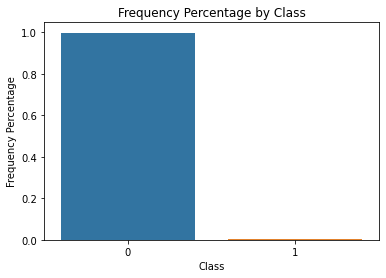

In [ ]:
count_classes = pd.value_counts(data['Class'],sort=True).sort_index()
ax = sns.barplot(x=count_classes.index, y=[tuple(count_classes/len(data))[0],tuple(count_classes/len(data))[1]])
ax.set_title('Frequency Percentage by Class')
ax.set_xlabel('Class')
ax.set_ylabel('Frequency Percentage')

# Model Preparation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataX, 
                                    dataY, test_size=0.33, 
                                    random_state=2018, stratify=dataY)

In [ ]:
len(X_train)

190820

In [ ]:
len(X_test)

93987

In [ ]:
y_train.sum()/len(y_train)

0.0017293784718582959

In [ ]:
y_test.sum()/len(y_test)

0.0017236426314277506

In [ ]:
# Feature scaling
featuresToScale = dataX.drop(['Time'],axis=1).columns

In [ ]:
featuresToScale

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [ ]:
# Suppress warnings
pd.set_option('mode.chained_assignment', None)

sX = pp.StandardScaler(copy=True)
X_train.loc[:,featuresToScale] = sX.fit_transform(X_train.loc[:,featuresToScale])
scalingFactors = pd.DataFrame(data=[sX.mean_,sX.scale_],index=['Mean','StDev'],columns=featuresToScale)

X_test.loc[:,featuresToScale] = sX.transform(X_test.loc[:,featuresToScale])

In [ ]:
scalingFactors

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Mean,0.000169,-0.001847,-0.002083,0.000909,0.002961,0.002817,-0.000048,-0.002589,-0.000516,0.000787,0.000403,-0.001410,-0.000012,0.000702,0.000038,0.000596,0.001182,0.002464,0.000574,-0.000925,0.001924,-0.000187,0.001501,-0.000785,0.000352,-0.000369,0.000434,0.000083,88.324359
StDev,1.965201,1.656922,1.513847,1.414958,1.385615,1.337316,1.244564,1.216633,1.097482,1.085226,1.019253,0.994948,0.995768,0.955115,0.916130,0.874185,0.842864,0.836401,0.815053,0.769595,0.752358,0.727151,0.626533,0.606504,0.522020,0.481376,0.402544,0.340144,246.692699


In [ ]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)

# Logistic Regression

In [ ]:
penalty = 'l2'
C = 1.0
class_weight = 'balanced'
random_state = 2018
solver = 'liblinear'
n_jobs = 1

logReg = LogisticRegression(penalty=penalty, C=C, 
            class_weight=class_weight, random_state=random_state, 
                            solver=solver, n_jobs=n_jobs)

In [ ]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                        index=y_train.index,columns=[0,1])

model = logReg

for train_index, cv_index in k_fold.split(np.zeros(len(X_train))
                                          ,y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, 
                               model.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = \
        model.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, 
                         predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLogisticRegression = log_loss(y_train, 
                                     predictionsBasedOnKFolds.loc[:,1])
print('Logistic Regression Log Loss: ', loglossLogisticRegression)

Training Log Loss:  0.10951353746607272
CV Log Loss:  0.10867783336234717
Training Log Loss:  0.10460227416593064
CV Log Loss:  0.10407451870069642
Training Log Loss:  0.1155100269830853
CV Log Loss:  0.11787700644717178
Training Log Loss:  0.11552991927823339
CV Log Loss:  0.11812642817093104
Training Log Loss:  0.09713987415636184
CV Log Loss:  0.09707857057711211
Logistic Regression Log Loss:  0.10916687145165169


In [ ]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLogisticRegression = preds.copy()

In [ ]:
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],
                                                       preds['prediction'])

In [ ]:
average_precision = average_precision_score(preds['trueLabel'],
                                            preds['prediction'])

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.74')

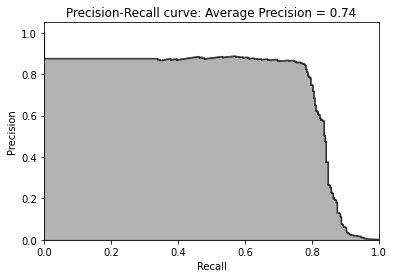

In [ ]:
plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

In [ ]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])

In [ ]:
areaUnderROC = auc(fpr, tpr)

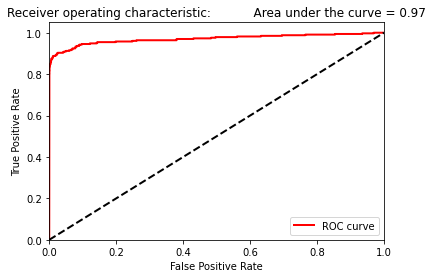

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
          Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Random Forests

In [ ]:
n_estimators = 10
max_features = 'auto'
max_depth = None
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0
max_leaf_nodes = None
bootstrap = True
oob_score = False
n_jobs = -1
random_state = 2018
class_weight = 'balanced'

RFC = RandomForestClassifier(n_estimators=n_estimators, 
        max_features=max_features, max_depth=max_depth,
        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf, 
        max_leaf_nodes=max_leaf_nodes, bootstrap=bootstrap, 
        oob_score=oob_score, n_jobs=n_jobs, random_state=random_state, 
        class_weight=class_weight)

In [ ]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                        index=y_train.index,columns=[0,1])

model = RFC

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, \
                                model.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = \
        model.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossRandomForestsClassifier = log_loss(y_train, 
                                          predictionsBasedOnKFolds.loc[:,1])
print('Random Forests Log Loss: ', loglossRandomForestsClassifier)

Training Log Loss:  0.0004717456539906082
CV Log Loss:  0.009958407581679842
Training Log Loss:  0.00039391696555908875
CV Log Loss:  0.012614958898596576
Training Log Loss:  0.00039619886266122875
CV Log Loss:  0.008321682857781797
Training Log Loss:  0.0004174848852259459
CV Log Loss:  0.009209166975528824
Training Log Loss:  0.00042710655140527107
CV Log Loss:  0.014292100977712807
Random Forests Log Loss:  0.010879263458259968


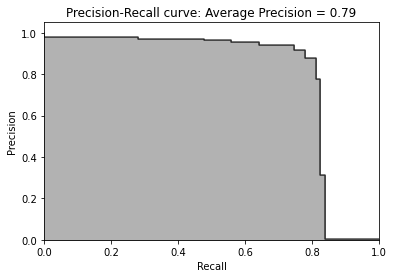

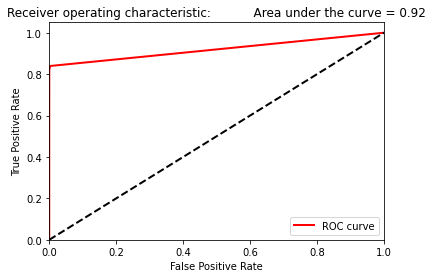

In [ ]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsRandomForests = preds.copy()

precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],
                                                       preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],
                                            preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
          Area under the curve = {0:0.2f}'.format(
          areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# XGBoost

To improve the user experience, I have commented out code blocks related to XGBoost. To uncomment the code blocks, highlight the code and use the "CTRL" + "/" key combination.

In [ ]:
# params_xGB = {
#     'nthread':16, #number of cores
#     'learning rate': 0.3, #range 0 to 1, default 0.3
#     'gamma': 0, #range 0 to infinity, default 0 
#         # increase to reduce complexity (increase bias, reduce variance)
#     'max_depth': 6, #range 1 to infinity, default 6
#     'min_child_weight': 1, #range 0 to infinity, default 1
#     'max_delta_step': 0, #range 0 to infinity, default 0
#     'subsample': 1.0, #range 0 to 1, default 1
#         # subsample ratio of the training examples
#     'colsample_bytree': 1.0, #range 0 to 1, default 1 
#         # subsample ratio of features
#     'objective':'binary:logistic',
#     'num_class':1,
#     'eval_metric':'logloss',
#     'seed':2018,
#     'silent':1
# }

In [ ]:
# trainingScores = []
# cvScores = []
# predictionsBasedOnKFolds = pd.DataFrame(data=[],
#                                     index=y_train.index,columns=['prediction'])

# for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),
#                                           y_train.ravel()):
#     X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
#         X_train.iloc[cv_index,:]
#     y_train_fold, y_cv_fold = y_train.iloc[train_index], \
#         y_train.iloc[cv_index]
    
#     dtrain = xgb.DMatrix(data=X_train_fold, label=y_train_fold)
#     dCV = xgb.DMatrix(data=X_cv_fold)
    
#     bst = xgb.cv(params_xGB, dtrain, num_boost_round=2000, 
#                  nfold=5, early_stopping_rounds=200, verbose_eval=50)
    
#     best_rounds = np.argmin(bst['test-logloss-mean'])
#     bst = xgb.train(params_xGB, dtrain, best_rounds)
    
#     loglossTraining = log_loss(y_train_fold, bst.predict(dtrain))
#     trainingScores.append(loglossTraining)
    
#     predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
#         bst.predict(dCV)
#     loglossCV = log_loss(y_cv_fold, \
#         predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
#     cvScores.append(loglossCV)
    
#     print('Training Log Loss: ', loglossTraining)
#     print('CV Log Loss: ', loglossCV)
    
# loglossXGBoostGradientBoosting = \
#     log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
# print('XGBoost Gradient Boosting Log Loss: ', loglossXGBoostGradientBoosting)

In [ ]:
# preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,'prediction']], axis=1)
# preds.columns = ['trueLabel','prediction']
# predictionsBasedOnKFoldsXGBoostGradientBoosting = preds.copy()

# precision, recall, thresholds = \
#     precision_recall_curve(preds['trueLabel'],preds['prediction'])
# average_precision = \
#     average_precision_score(preds['trueLabel'],preds['prediction'])

# plt.step(recall, precision, color='k', alpha=0.7, where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])

# plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
#           average_precision))

# fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
# areaUnderROC = auc(fpr, tpr)

# plt.figure()
# plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
# plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic: \
#         Area under the curve = {0:0.2f}'.format(areaUnderROC))
# plt.legend(loc="lower right")
# plt.show()

# LightGBM

In [ ]:
params_lightGB = {
    'task': 'train',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': -1,
    'num_threads':16
}

In [ ]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, \
                gbm.predict(X_train_fold, num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = \
    log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.00626392
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00619722
[3]	valid_0's binary_logloss: 0.00612709
[4]	valid_0's binary_logloss: 0.00607428
[5]	valid_0's binary_logloss: 0.0060139
[6]	valid_0's binary_logloss: 0.005965
[7]	valid_0's binary_logloss: 0.00591106
[8]	valid_0's binary_logloss: 0.00585687
[9]	valid_0's binary_logloss: 0.00580189
[10]	valid_0's binary_logloss: 0.00575339
[11]	valid_0's binary_logloss: 0.00570291
[12]	valid_0's binary_logloss: 0.00565458
[13]	valid_0's binary_logloss: 0.00560416
[14]	valid_0's binary_logloss: 0.00555768
[15]	valid_0's binary_logloss: 0.00551172
[16]	valid_0's binary_logloss: 0.00546648
[17]	valid_0's binary_logloss: 0.00542383
[18]	valid_0's binary_logloss: 0.00538608
[19]	valid_0's binary_logloss: 0.00534511
[20]	valid_0's binary_logloss: 0.00530607
[21]	valid_0's binary_logloss: 0.00526582
[22]	valid_0's binary_logloss: 0.00522774
[23]	valid_0's binary_log

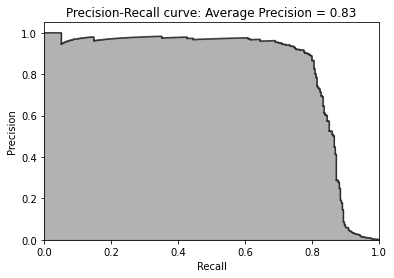

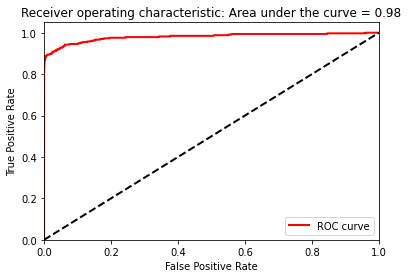

In [ ]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLightGBMGradientBoosting = preds.copy()

precision, recall, thresholds = \
    precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = \
    average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Test Set Evaluation

In [ ]:
predictionsTestSetLogisticRegression = \
    pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetLogisticRegression.loc[:,'prediction'] = \
    logReg.predict_proba(X_test)[:,1]
logLossTestSetLogisticRegression = \
    log_loss(y_test, predictionsTestSetLogisticRegression)

In [ ]:
predictionsTestSetRandomForests = \
    pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetRandomForests.loc[:,'prediction'] = \
    RFC.predict_proba(X_test)[:,1]
logLossTestSetRandomForests = \
    log_loss(y_test, predictionsTestSetRandomForests)

In [ ]:
# predictionsTestSetXGBoostGradientBoosting = \
#     pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
# dtest = xgb.DMatrix(data=X_test)
# predictionsTestSetXGBoostGradientBoosting.loc[:,'prediction'] = \
#     bst.predict(dtest)
# logLossTestSetXGBoostGradientBoosting = \
#     log_loss(y_test, predictionsTestSetXGBoostGradientBoosting)

In [ ]:
predictionsTestSetLightGBMGradientBoosting = \
    pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetLightGBMGradientBoosting.loc[:,'prediction'] = \
    gbm.predict(X_test, num_iteration=gbm.best_iteration)
logLossTestSetLightGBMGradientBoosting = \
    log_loss(y_test, predictionsTestSetLightGBMGradientBoosting)

In [ ]:
print("Log Loss of Logistic Regression on Test Set: ", \
          logLossTestSetLogisticRegression)
print("Log Loss of Random Forests on Test Set: ", \
          logLossTestSetRandomForests)
# print("Log Loss of XGBoost Gradient Boosting on Test Set: ", \
#           logLossTestSetXGBoostGradientBoosting)
print("Log Loss of LightGBM Gradient Boosting on Test Set: ", \
          logLossTestSetLightGBMGradientBoosting)

Log Loss of Logistic Regression on Test Set:  0.09686247466781985
Log Loss of Random Forests on Test Set:  0.009037864825132656
Log Loss of LightGBM Gradient Boosting on Test Set:  0.002538541967525037


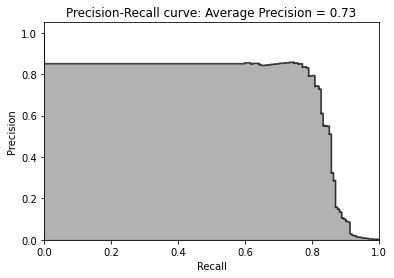

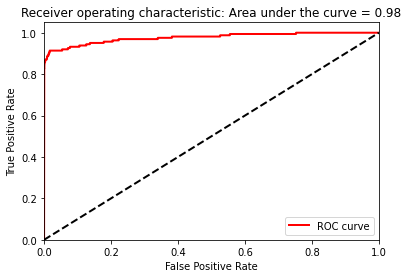

In [ ]:
precision, recall, thresholds = \
    precision_recall_curve(y_test,predictionsTestSetLogisticRegression)
average_precision = \
    average_precision_score(y_test,predictionsTestSetLogisticRegression)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(y_test,predictionsTestSetLogisticRegression)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

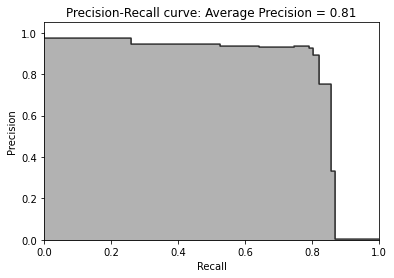

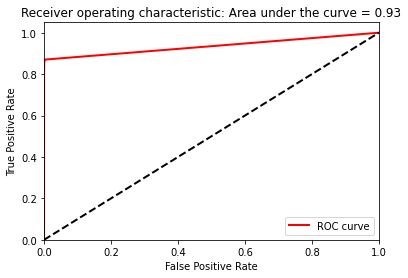

In [ ]:
precision, recall, thresholds = \
    precision_recall_curve(y_test,predictionsTestSetRandomForests)
average_precision = \
    average_precision_score(y_test,predictionsTestSetRandomForests)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(y_test,predictionsTestSetRandomForests)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

In [ ]:
# precision, recall, thresholds = \
#     precision_recall_curve(y_test,predictionsTestSetXGBoostGradientBoosting)
# average_precision = \
#     average_precision_score(y_test,predictionsTestSetXGBoostGradientBoosting)

# plt.step(recall, precision, color='k', alpha=0.7, where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])

# plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
#           average_precision))

# fpr, tpr, thresholds = \
#     roc_curve(y_test,predictionsTestSetXGBoostGradientBoosting)
# areaUnderROC = auc(fpr, tpr)

# plt.figure()
# plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
# plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic: \
# Area under the curve = {0:0.2f}'.format(areaUnderROC))
# plt.legend(loc="lower right")
# plt.show()

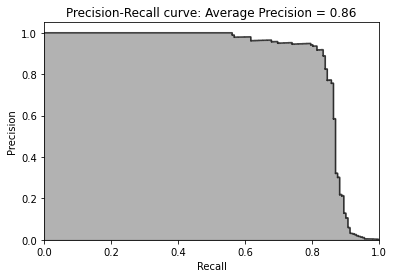

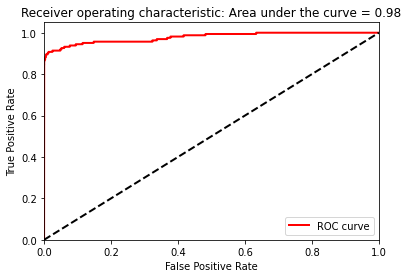

In [ ]:
precision, recall, thresholds = \
    precision_recall_curve(y_test,predictionsTestSetLightGBMGradientBoosting)
average_precision = \
    average_precision_score(y_test,predictionsTestSetLightGBMGradientBoosting)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = \
    roc_curve(y_test,predictionsTestSetLightGBMGradientBoosting)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Ensemble

In [ ]:
# Without XGBoost
predictionsBasedOnKFoldsFourModels = pd.DataFrame(data=[],index=y_train.index)
predictionsBasedOnKFoldsFourModels = predictionsBasedOnKFoldsFourModels.join(
    predictionsBasedOnKFoldsLogisticRegression['prediction'].astype(float), \
    how='left').join(predictionsBasedOnKFoldsRandomForests['prediction'] \
    .astype(float),how='left',rsuffix="2").join( \
    predictionsBasedOnKFoldsLightGBMGradientBoosting['prediction'].astype(float), \
    how='left',rsuffix="4")
predictionsBasedOnKFoldsFourModels.columns = \
    ['predsLR','predsRF','predsLightGBM']

# predictionsBasedOnKFoldsFourModels = pd.DataFrame(data=[],index=y_train.index)
# predictionsBasedOnKFoldsFourModels = predictionsBasedOnKFoldsFourModels.join(
#     predictionsBasedOnKFoldsLogisticRegression['prediction'].astype(float), \
#     how='left').join(predictionsBasedOnKFoldsRandomForests['prediction'] \
#     .astype(float),how='left',rsuffix="2").join( \
#     predictionsBasedOnKFoldsXGBoostGradientBoosting['prediction'].astype(float), \
#     how='left',rsuffix="3").join( \
#     predictionsBasedOnKFoldsLightGBMGradientBoosting['prediction'].astype(float), \
#     how='left',rsuffix="4")
# predictionsBasedOnKFoldsFourModels.columns = \
#     ['predsLR','predsRF','predsXGB','predsLightGBM']

In [ ]:
X_trainWithPredictions = \
    X_train.merge(predictionsBasedOnKFoldsFourModels,
                  left_index=True,right_index=True)

In [ ]:
params_lightGB = {
    'task': 'train',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': -1,
    'num_threads':16
}

In [ ]:
trainingScores = []
cvScores = []
predictionsBasedOnKFoldsEnsemble = \
    pd.DataFrame(data=[],index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = \
        X_trainWithPredictions.iloc[train_index,:], \
        X_trainWithPredictions.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, \
        gbm.predict(X_train_fold, num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFoldsEnsemble.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFoldsEnsemble.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossEnsemble = log_loss(y_train, \
        predictionsBasedOnKFoldsEnsemble.loc[:,'prediction'])
print('Ensemble Log Loss: ', loglossEnsemble)

[1]	valid_0's binary_logloss: 0.00575886
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00567831
[3]	valid_0's binary_logloss: 0.00560729
[4]	valid_0's binary_logloss: 0.00554732
[5]	valid_0's binary_logloss: 0.00549666
[6]	valid_0's binary_logloss: 0.00543655
[7]	valid_0's binary_logloss: 0.00538611
[8]	valid_0's binary_logloss: 0.00533869
[9]	valid_0's binary_logloss: 0.00528248
[10]	valid_0's binary_logloss: 0.00524013
[11]	valid_0's binary_logloss: 0.00519067
[12]	valid_0's binary_logloss: 0.00514459
[13]	valid_0's binary_logloss: 0.00509982
[14]	valid_0's binary_logloss: 0.00506104
[15]	valid_0's binary_logloss: 0.00501864
[16]	valid_0's binary_logloss: 0.00497562
[17]	valid_0's binary_logloss: 0.00493932
[18]	valid_0's binary_logloss: 0.00490112
[19]	valid_0's binary_logloss: 0.00486511
[20]	valid_0's binary_logloss: 0.00482876
[21]	valid_0's binary_logloss: 0.004794
[22]	valid_0's binary_logloss: 0.00475979
[23]	valid_0's binary_lo

In [ ]:
print('Feature importances:', list(gbm.feature_importance()))

Feature importances: [127, 118, 64, 129, 165, 61, 68, 119, 180, 91, 182, 99, 168, 169, 362, 43, 177, 37, 67, 323, 95, 86, 146, 42, 171, 213, 248, 95, 110, 438, 186, 152, 427]


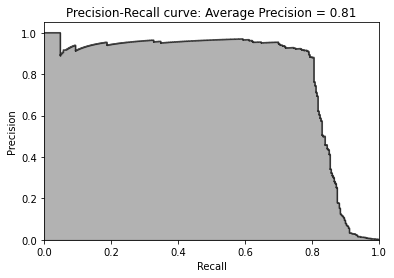

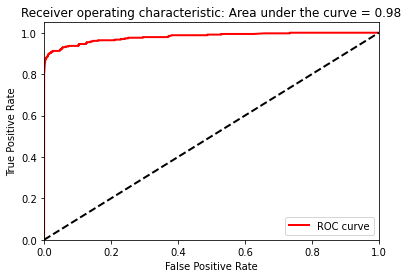

In [ ]:
preds = pd.concat([y_train,predictionsBasedOnKFoldsEnsemble.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']

precision, recall, thresholds = \
    precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = \
    average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

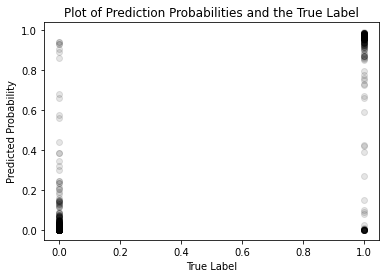

In [ ]:
scatterData = predictionsTestSetLightGBMGradientBoosting.join(y_test,how='left')
scatterData.columns = ['Predicted Probability','True Label']
ax = sns.regplot(x="True Label", y="Predicted Probability", color='k', 
                 fit_reg=False, scatter_kws={'alpha':0.1},
                 data=scatterData).set_title( \
                'Plot of Prediction Probabilities and the True Label')

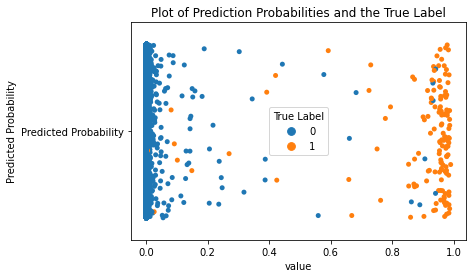

In [ ]:
scatterDataMelted = pd.melt(scatterData, "True Label", \
                            var_name="Predicted Probability")
ax = sns.stripplot(x="value", y="Predicted Probability", \
                   hue='True Label', jitter=0.4, \
                   data=scatterDataMelted).set_title( \
                   'Plot of Prediction Probabilities and the True Label')

In [ ]:
# Pipeline for New Data
# first, import new data into a dataframe called 'newData'
# second, scale data
# newData.loc[:,featuresToScale] = sX.transform(newData[featuresToScale])
# third, predict using LightGBM
# gbm.predict(newData, num_iteration=gbm.best_iteration)

# Conclusion